In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Just for in this notebook
import sys
sys.path.append('../assignment1/to_hand_in/')

import some_routines as sr
from tqdm import tqdm_notebook as tqdm

# 5. Mass assignment schemes

#### $S(x)$ is the mass density at the distance $x$ from the particle for cell size $\Delta x$. We use periodic boundary conditions. 

#### a). The most simple choice for the particle shape is a point-like shape given by
\begin{equation}
S(x) = \frac{1}{\Delta x} \delta(\frac{x}{\Delta x})
\end{equation}
#### Explain how we need to assign mass in this scheme and explain why this method is called the NGP method. Code up this method yourself, display slices

The fraction of a particle's mass assigned to it's nearest cell $ijk$ is the integral of the shape function over this cell:
\begin{equation}
W_x = \int_{x_{ijk} - \Delta x /2}^{x_{ijk} - \Delta x /2} S(x_p - x') dx'
\end{equation}
which is equivalent for the $y$ and $z$ directions. The product of the three directions is then the fraction of mass $W$. Thus the mass in a cell is in this case given as the mass of the particles that are in the cell
\begin{equation}
M_{ijk} = \sum_{p=1}^{N_p} m_p W(\vec{r}_p - \vec{r}_{ijk}) 
\end{equation}
In our implementation we simply loop over all particles once and assign their mass to the nearest cell point. 

Reference: http://background.uchicago.edu/~whu/Courses/Ast321_11/pm.pdf

In [2]:
class NGP(object):
    def __init__(self, nperdim, positions):
        """
        nperdim   -- int: amount of points per dimension
        positions -- array: 3D positions of the particles (3,?)
        """
        self.nperdim = nperdim
        # Particle positions [xvalues,yvalues,zvalues]
        self.positions = positions
        # 1D grid positions
        self.onedim = sr.linspace(0,nperdim, nperdim+1)
        # 3D Grid positions, shape (3,nperdim,nperdim,nperdim)
        self.grid = np.meshgrid(self.onedim,self.onedim,self.onedim)
        # cell size
        self.deltax = 1
        # Masses of the gridpoints
        self.massgrid = self.assign_mass()
        
    def assign_mass(self):
        massgrid = np.zeros((self.nperdim,self.nperdim,self.nperdim))
        # Index of the cell containing the particle is floored int
        indices = np.array(self.positions, dtype='int')
        # Assign each particle mass to its nearest gridpoint
        for i in range(indices.shape[1]):
            massgrid[tuple(indices[:,i])] += 1
        return massgrid

In [3]:
# Particle positions
np.random.seed(121)
positions = np.random.uniform(low=0,high=16,size=(3,1024))

In [4]:
ngp = NGP(16,positions)

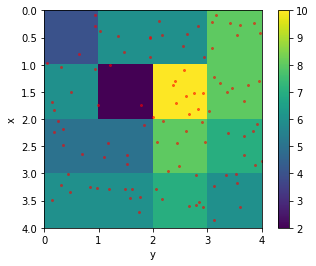

4 4.0
8 8.0


In [5]:
# TEST cell
postest = np.random.uniform(low=0,high=4,size=(3,100))
ngptest = NGP(4,postest)

# Remember that x is the first axis and y is the second, so switch
plt.scatter(postest[1],postest[0],s=4,c='r',alpha=0.5)
plt.imshow(np.sum(ngptest.massgrid,axis=2),extent=[0,4,4,0])
plt.colorbar()
plt.xlabel('y')
plt.ylabel('x')
plt.title("TEST")
plt.savefig('./test.pdf')
plt.show()

print (np.sum((postest[0] < 1) & (postest[1]<1) )
       ,np.sum(ngptest.massgrid[0,0]))
print (np.sum((postest[0] > 1) & (postest[1]>3) 
             &(postest[0] < 2) & (postest[1]<4))
       ,np.sum(ngptest.massgrid[1,3]))

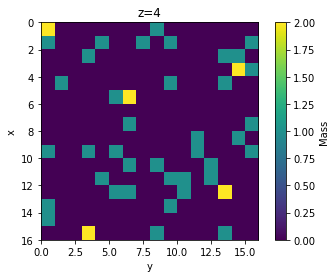

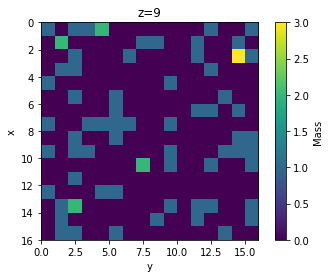

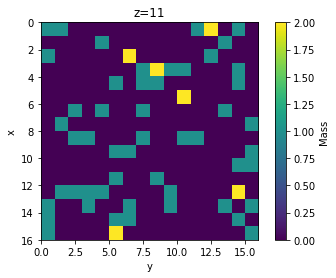

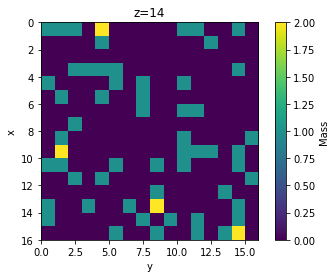

In [6]:
for z in [4,9,11,14]:
    plt.title(f"z={z}")
    # Fix the imshow axes with extent
    plt.imshow(ngp.massgrid[:,:,z],extent=[0,16,16,0])
    cbar = plt.colorbar()
    cbar.set_label('Mass')
    # remember switch x and y in arrays
    plt.xlabel('y')
    plt.ylabel('x')
#     plt.savefig('./test.pdf')
    plt.show()

#### b) To check the robustness of your implementation make a plot of the $x$ position of an individual particle and the value in cell 4 in 1 dimension. Let $x$ vary from the lowest value to the highest possible value in $x$. Repeat for cell 0

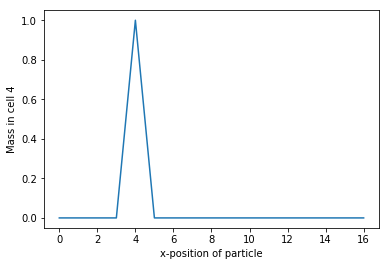

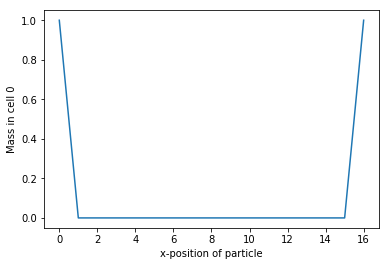

In [7]:
all_x = sr.linspace(0,16,17)
cell4 = []
cell0 = []
for x in all_x:
    x = x%16 # periodic boundary conditions
    testpos = np.array([x,0,0])[:,np.newaxis] 
    ngp = NGP(16,testpos)
    cell4.append(ngp.massgrid[4,0,0])
    cell0.append(ngp.massgrid[0,0,0])
    
plt.plot(all_x,cell4)
plt.ylabel('Mass in cell 4')
plt.xlabel('x-position of particle')
plt.show()

plt.plot(all_x,cell0)
plt.ylabel('Mass in cell 0')
plt.xlabel('x-position of particle')
plt.show()

#### c) Now use method that assumes particles are 3D cubes of uniform density and have the size of a grid cell. This means the particle shape is given by ..

#### Calculate how mass needs to be assigned in this case (Cloud in Cell method and implement it in code. To check the robustness make the same plots as before (in a and b)

For CIC, the particle can contribute to the cell it is currently in and the seven (in 3D) other neighbouring cells. We can define $dx = x_p - x_c$ as the distance between the particle and the cell, and $t_x = 1-d_x$. Then the contributions of mass to each of the eight cells are linear interpolations, coded up below.

In [8]:
class CIC(object):
    def __init__(self, nperdim, positions):
        """
        nperdim   -- int: amount of gridpoints per dimension
        positions -- array: 3D positions of the particles (3,?)
        """
        self.nperdim = nperdim
        # Particle positions [xvalues,yvalues,zvalues]
        self.positions = positions
        # 1D grid positions
        self.onedim = sr.linspace(0,nperdim, nperdim+1)
        # 3D Grid positions, shape (3,nperdim,nperdim,nperdim)
        self.grid = np.meshgrid(self.onedim,self.onedim,self.onedim)
        # cell size
        self.deltax = 1
        # Masses of the gridpoints
        self.massgrid = self.assign_mass()
        
    def assign_mass(self):
        """
        Use the CIC method to assign mass to all the cells
        """
        massgrid = np.zeros((self.nperdim,self.nperdim,self.nperdim))
        # Index of the cell containing the particle is floored int
        indices = np.array(self.positions, dtype='int')
        # Distances to nearest grid point
        dr = self.positions-indices
        tr = 1-dr
        
        # Assign each particle mass to 8 gridpoints
        for i in range(indices.shape[1]):
            indx = indices[:,i]
            # Current cell
            massgrid[tuple(indx)] += np.prod(tr[:,i])
            # Neighbours. Note periodic boundary conditions
            idx = tuple((indx+np.array([1,0,0]))%self.nperdim)
            massgrid[idx] += dr[0,i]*tr[1,i]*tr[2,i]
            idx = tuple((indx+np.array([0,1,0]))%self.nperdim)
            massgrid[idx] += tr[0,i]*dr[1,i]*tr[2,i]
            idx = tuple((indx+np.array([1,1,0]))%self.nperdim)
            massgrid[idx] += dr[0,i]*dr[1,i]*tr[2,i]
            idx = tuple((indx+np.array([0,0,1]))%self.nperdim)
            massgrid[idx] += tr[0,i]*tr[1,i]*dr[2,i]
            idx = tuple((indx+np.array([1,0,1]))%self.nperdim)
            massgrid[idx] += dr[0,i]*tr[1,i]*dr[2,i]
            idx = tuple((indx+np.array([0,1,1]))%self.nperdim)
            massgrid[idx] += tr[0,i]*dr[1,i]*dr[2,i]
            idx = tuple((indx+np.array([1,1,1]))%self.nperdim)
            massgrid[idx] += dr[0,i]*dr[1,i]*dr[2,i]
        return massgrid
    
    def compute_force(self, pindices, potential):
        """
        Return gradient of the potential 
        (= -1*Force for unit mass particles.)
        The gradient of the potential is calculated with inverse CIC
        interpolation.
        
        pindices  -- list of integers, the indices of the particles
                     to compute the gradient for.
                     --> must be between 0 and len(self.positions)
                     
        potential -- 3D array, the potential of every cell
        
        Returns
        all_gradients -- array of shape (len(pindices),3)
                         containing for every particle the 3D gradient
        """
        # Calculate gradient in x direction of every cell
        # with central difference method
        Fx = (np.roll(potential,-1,axis=0) - np.roll(potential,1,axis=0))/(2*self.deltax)
        # Repeat for y and z direction, shape (Nperdim,Nperdim,Nperdim)
        Fy = (np.roll(potential,-1,axis=1) - np.roll(potential,1,axis=1))/(2*self.deltax)
        Fz = (np.roll(potential,-1,axis=2) - np.roll(potential,1,axis=2))/(2*self.deltax)
        
        gradpot = np.zeros((self.nperdim,self.nperdim,self.nperdim,3))
        gradpot[:,:,:,0] = Fx
        gradpot[:,:,:,1] = Fy
        gradpot[:,:,:,2] = Fz
        
        # Indices of the cells containing the particles is floored int
        indices = np.array(self.positions[:,pindices], dtype='int')
                
        # Distance to nearest grid point for every particle
        dr = self.positions[:,pindices]-indices
        tr = 1-dr
        
        # Intepolate each of the 8 gridpoints contribution to the
        # single value for the gradient of the potential
        all_gradients = np.zeros((len(pindices),3)) # each particle has 3D gradient 
        for i in range(len(pindices)):
            # parent cell
            indx = indices[:,i]
            grad = gradpot[tuple(indx)]*np.prod(tr[:,i])
            # Neighbours. Note periodic boundary conditions
            idx = tuple((indx+np.array([1,0,0]))%self.nperdim)
            grad += gradpot[idx]*dr[0,i]*tr[1,i]*tr[2,i]
            
            idx = tuple((indx+np.array([0,1,0]))%self.nperdim)
            grad += gradpot[idx]*tr[0,i]*dr[1,i]*tr[2,i]
            
            idx = tuple((indx+np.array([1,1,0]))%self.nperdim)
            grad += gradpot[idx]*dr[0,i]*dr[1,i]*tr[2,i]
            
            idx = tuple((indx+np.array([0,0,1]))%self.nperdim)
            grad += gradpot[idx]*tr[0,i]*tr[1,i]*dr[2,i]
            
            idx = tuple((indx+np.array([1,0,1]))%self.nperdim)
            grad += gradpot[idx]*dr[0,i]*tr[1,i]*dr[2,i]
            
            idx = tuple((indx+np.array([0,1,1]))%self.nperdim)
            grad += gradpot[idx]*tr[0,i]*dr[1,i]*dr[2,i]
            
            idx = tuple((indx+np.array([1,1,1]))%self.nperdim)
            grad += gradpot[idx]*dr[0,i]*dr[1,i]*dr[2,i]
            
            all_gradients[i,:] = grad
            
        return all_gradients

In [9]:
cic = CIC(16,positions)

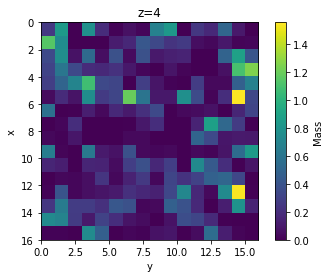

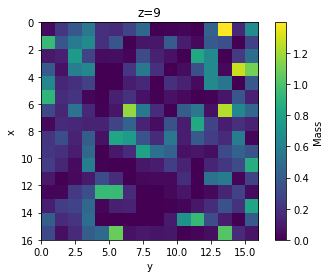

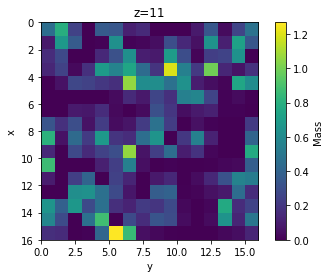

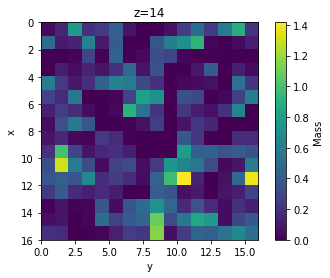

In [10]:
for z in [4,9,11,14]:
    plt.title(f"z={z}")
    plt.imshow(cic.massgrid[:,:,z],extent=[0,16,16,0])
    cbar = plt.colorbar()
    cbar.set_label('Mass')
    plt.xlabel('y')
    plt.ylabel('x')
#     plt.savefig('./test.pdf')
    plt.show()

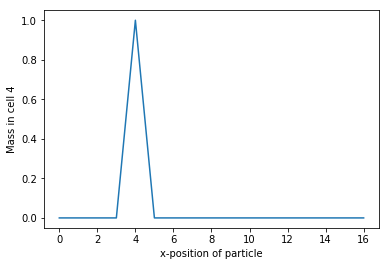

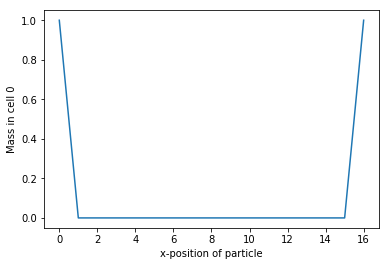

In [11]:
all_x = sr.linspace(0,16,17)
cell4 = []
cell0 = []
for x in all_x:
    x = x%16 # periodic boundary conditions
    testpos = np.array([x,0,0])[:,np.newaxis] 
    cicc = CIC(16,testpos)
    cell4.append(cicc.massgrid[4,0,0])
    cell0.append(cicc.massgrid[0,0,0])
    
plt.plot(all_x,cell4)
plt.ylabel('Mass in cell 4')
plt.xlabel('x-position of particle')
plt.show()

plt.plot(all_x,cell0)
plt.ylabel('Mass in cell 0')
plt.xlabel('x-position of particle')
plt.show()

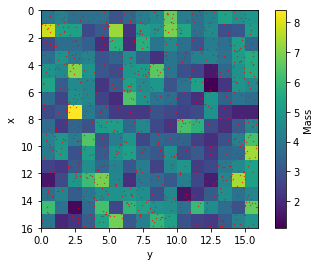

In [12]:
# TEST CELL
cic = CIC(16,positions)
plt.scatter(positions[1],positions[0],c='r',s=0.1)
plt.imshow(np.sum(cic.massgrid[:,:,:],axis=2),extent=[0,16,16,0])
cbar = plt.colorbar()
cbar.set_label('Mass')
# remember switch x and y axis
plt.xlabel('y')
plt.ylabel('x')
plt.savefig('./test2.pdf')
plt.show()

#### d) Write your own FFT algorithm, check that your code works with a 1D function (no Gaussian) by making a plot of the FFT and compare your result with a python package and the analytical FFT of your function. For the rest of the exercise use your own FFT

We define the discrete Fourier transform following the convention used by \textit{Numpy} as follows:
\begin{equation}
H_k = \sum_{n=0}^{N-1} h_n e^{-i2\pi k n /N}
\end{equation}
and the inverse transform as 
\begin{equation}
h_n = \frac{1}{N} \sum_{k=0}^{N-1} H_k e^{i2\pi k n/N}
\end{equation}
where $N$ is the number of samples and $h_n$ the sampled values. We keep the $1/N$ normalization out of the python functions for convenience, but make sure to normalize it properly after calling an inverse Fourier transform routine.

In [13]:
def FFT1D(x, IFT=False):
    """
    Perform the (i)FFT of input array x using the Cooley-Tukey algorithm
    No normalization
    """
    N = len(x)
    # change the factor when doing IFT
    if IFT:
        fi = 1
    else:
        fi = -1
        
    if N > 1:
        # split in even and odd elements
        ffteven = FFT1D(x[0::2])
        fftodd = FFT1D(x[1::2])
        
        # Exploit the period in k, vectorize instead of loop
        if N//2-1 == 0:
            k = 0 # prevent division by zero error in linspace
        else:
            k = sr.linspace(0,N//2-1,N//2)
            
        W = np.exp(fi*2j*np.pi*k/N)*fftodd
        return np.concatenate([ffteven + W
                       , ffteven-W])
    else:
        return x
        

We choose the function 
\begin{equation}
f(x) = 2\sin(2\pi A x) 
\end{equation}
Of which the Fourier transform is trivially given by
\begin{equation}
f(k) = \frac{1}{2i}(\delta(k-A) - \delta(k+A))
\end{equation}
Thus we expect a delta function at $k=A$ and $k=-A$, we choose $A = 1$ in the code below.


In [14]:
def function(x):
    return 2*np.sin(2*np.pi*x)

N = 64 # amount of samples
x = sr.linspace(0,6*np.pi,N)
# sample spacing
dt = 6*np.pi/64
# k vector, positive part only
ks = np.array(sr.linspace(0, (N-1)//2,(N-1)//2 + 1))
ks /= N*dt
                         
fx = function(x)
fk = FFT1D(fx)
fknp = np.fft.fft(fx)

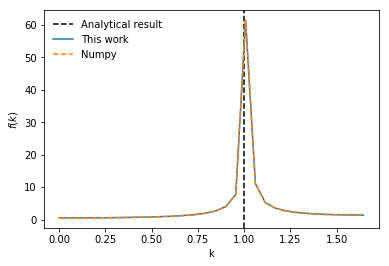

In [15]:
# Symmetric, only plot half of the plane
plt.axvline(1.0,ls='dashed',c='k',label='Analytical result')
plt.plot(ks,np.abs(fk)[:N//2],label='This work')
plt.plot(ks,np.abs(fknp)[:N//2],label='Numpy',ls='dashed')
plt.xlabel('k')
plt.ylabel('$f(k)$')
plt.legend(frameon=False,loc='upper left')
plt.show()

#### e) Generalize your own FFT algorithm to 2 and 3 dimensions and make a plot of the FFT of a 2D function and compare it with the analytical FFT. Also make a plot of the FFT of a 3D multivariate Gaussian, plot 3 slices centered at the center for the 3 different slice options

For the 2D function we choose the function
\begin{equation}
2\sin\left(\frac{\pi}{2}(x+y)\right)
\end{equation}
Analogously to the 1D Fourier transform, we now expect two delta functions per dimension, at $k_{x,y} = \pm \frac{1}{4}$. Thus the 2D Fourier transform will show a square where corners are at the four possible combinations of $(k_{x},k_y)$.

In [16]:
def FFT2D(x, IFT=False):
    """
    Perform the FFT of 2D input array x 
    by nesting 1D Fourier transforms, see FFT1D(x)
    """
    FFT = np.array(np.zeros(x.shape),dtype=np.complex)
    # Take 1D fourier transform across rows
    for row in range(x.shape[0]):
        FFT[row,:] = FFT1D(x[row,:],IFT)
    # Then take 1D fourier transform across the columns
    for col in range(x.shape[1]):
        FFT[:,col] = FFT1D(FFT[:,col],IFT)
        
    return FFT

def FFT3D(x, IFT=False):
    """
    Perform the FFT of 3D input array x 
    by doing a 2D Fourier transform x.shape[0] times
    and then doing x.shape[1]*x.shape[2] 1D fourier transforms
    """
    FFT = np.array(x,dtype=np.complex)
    # Take 2D fourier transform across first axis
    for axis in range(x.shape[0]):
        FFT[axis,:,:] = FFT2D(FFT[axis,:,:],IFT)
    # Then take 1D fourier transform of the rest
    for i in range(x.shape[1]):
        for j in range(x.shape[2]):
            FFT[:,i,j] = FFT1D(FFT[:,i,j],IFT)
            
    return FFT    

In [17]:
def function(x, y):
    return 2*np.sin(1/2*np.pi*(x+y))

In [18]:
xx, yy = np.meshgrid(x,x)
fxy = function(xx,yy)

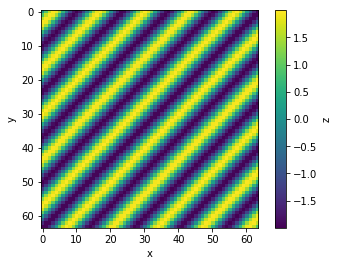

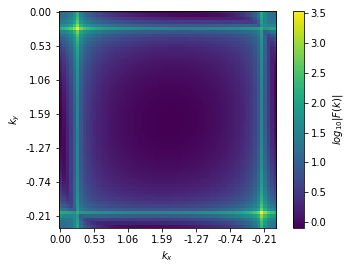

In [19]:
# Negative part of k vector, for the axis tick labels
ksneg = -1/dt/N*np.array(sr.linspace(0, (N-1)//2+1,(N-1)//2+2))[1:] # * 2*np.pi
kstot = np.concatenate([ks,ksneg[::-1]])

plt.imshow(fxy.real);
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('z')
plt.show()

fkk = FFT2D(fxy)
plt.imshow(np.fft.fftshift(np.abs(fkk)))
plt.imshow(np.log10(np.abs(fkk)))
ax = plt.gca()
# Fix axes labels so it shows the frequency 
# Add another zero because matplotlib ignores first tick
# for some reason
labels = [0] + [f'{kstot[i]:.2f}' for i in range(0,70,10)]
ax.set_yticklabels(labels)
ax.set_xticklabels(labels)
plt.xlabel('$k_x$')
plt.ylabel('$k_y$')
cbar = plt.colorbar()
cbar.set_label('$log_{10} |F(k)|$')
plt.show()

We see that indeed the four corners of the square are at $(k_x,k_y) = (\frac{1}{4},\frac{1}{4});(\frac{-1}{4},\frac{1}{4});(\frac{1}{4},\frac{-1}{4});(\frac{-1}{4},\frac{-1}{4})$

In [65]:
def multivariateGauss(x, mean,covariance):
    """
    Returns the PDF of a multivariate (n-D) Gaussian.
    Assumes the mean is a vector of length n
    and the covariance is a nxn DIAGONAL matrix.
    (if the matrix is not diagonal, the inverse will fail)
    """
    n = len(mean)
    # Calculate determinant and inverse of DIAGONAL covariance
    detcov = 1
    invcov = np.copy(covariance)
    for i in range(n):
        detcov *= covariance[i,i]
        invcov[i,i] = invcov[i,i]**-1.
    # assume dot product is elemental math enough that we can use it
    return ( (2*np.pi)**(-n/2) * (detcov)**(-0.5) 
            * np.exp(-0.5* np.dot((x-mean).T,
                    np.dot(invcov,(x-mean))) ) 
           )

In [77]:
mean = np.array([0.,1.,2.])
# diagonal covariance [3,2,1]
covariance = np.array([[3., 0., 0.],[0., 2., 0.],[0., 0., 1.]])

In [78]:
# Should make generating the k vector a function

N = 16 # amount of samples per dimension
all_x = sr.linspace(-3,3,N)
# sample spacing
dt = 6/64
# k vector, positive part only
ks = np.array(sr.linspace(0, (N-1)//2,(N-1)//2 + 1))
ks /= N*dt
# Negative part of k vector, for the axis tick labels
ksneg = -1/dt/N*np.array(sr.linspace(0, (N-1)//2+1,(N-1)//2+2))[1:] # * 2*np.pi
kstot = np.concatenate([ks,ksneg[::-1]])

In [79]:
multivariateGauss(x, mean, covariance)

0.001290538979596019

In [80]:
triGauss = np.zeros((N,N,N))
for i, xc in enumerate(all_x):
    for j, yc in enumerate(all_x):
        for k, zc in enumerate(all_x):
            x = np.array([xc,yc,zc])
            triGauss[i,j,k] = multivariateGauss(x, mean, covariance)
            
triGaussFT = FFT3D(triGauss)

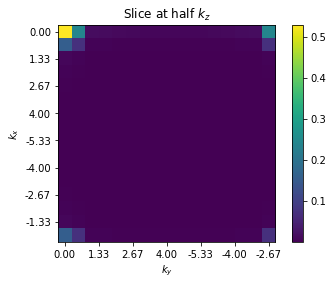

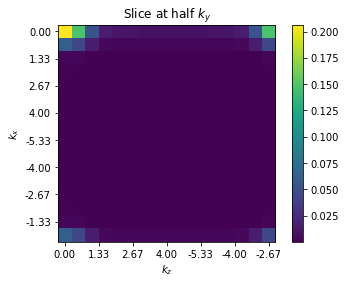

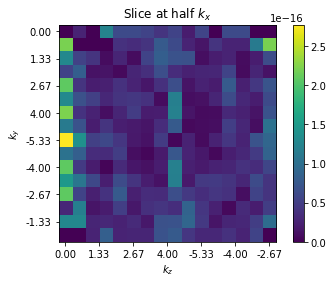

In [85]:
plt.title('Slice at half $k_z$')
plt.imshow(np.abs(triGaussFT[:,:,8]))
cbar = plt.colorbar()
plt.xlabel('$k_y$')
plt.ylabel('$k_x$')
# Fix axes labels so it shows the frequency 
labels = [0] + [f'{kstot[i]:.2f}' for i in range(0,N,2)]
ax = plt.gca()
ax.set_yticklabels(labels)
ax.set_xticklabels(labels)
plt.show()

plt.title('Slice at half $k_y$')
plt.imshow(np.abs(triGaussFT[:,8,:]))
cbar = plt.colorbar()
plt.xlabel('$k_z$')
plt.ylabel('$k_x$')
# Fix axes labels so it shows the frequency 
ax = plt.gca()
labels = [0] + [f'{kstot[i]:.2f}' for i in range(0,N,2)]
ax.set_yticklabels(labels)
ax.set_xticklabels(labels)

plt.show()

plt.title('Slice at half $k_x$')
plt.imshow(np.abs(triGaussFT[8,:,:]))
cbar = plt.colorbar()
plt.xlabel('$k_z$')
plt.ylabel('$k_y$')
# Fix axes labels so it shows the frequency 
ax = plt.gca()
labels = [0] + [f'{kstot[i]:.2f}' for i in range(0,N,2)]
ax.set_yticklabels(labels)
ax.set_xticklabels(labels)
plt.show()

#### f) Consider again the CIC method, before this we calculated the mesh. Reduce the values of the mesh by subtracting the average and dividing by the average as $$\delta = (\rho - <\rho>)/<\rho>.$$ We know that in GR is described by the Poisson equation which can be expressed as $$\nabla^2 \Phi \propto \delta,$$ in this case it is easier to calculate the FFT of the potential and transform is back:
\begin{equation}
\nabla^2 \Phi \propto \delta \rightarrow \overrightarrow{FFT} \rightarrow k^2 \hat{\Phi} \\ \hat{\Phi} \propto \frac{\hat{\delta}}{k^2}
\end{equation}
#### After this the inverse FFT is taken and the potential is determined. Calculate the potential up to a constant for the same particles. Again make a plot of the potential of $x-y$ slices with $z$ values of 4,9,11 and 14. Also make a centered slice for the $x-z$ and $y-z$ plane.

In [35]:
# Use this function again
def kvector(N,ndim):
    """
    Generate NxN(xN)xndim matrix of k vector values
    Since we need to do the IFFT of k*c_k
    we also need this kvector array
    """
    dk = 2*np.pi/N
    ks = [] # aranged vector of kx modes
    # Loop over all kx modes
    for i in range(0,N): 
        if i <= N//2:
            ks.append(dk*i)
        else:
            ks.append((-N+i)*dk)
            
    # My implementation of the c_field has a different definition
    # for the x axis than numpy, thus swap y and x from np.meshgrid
    if ndim == 2:
        # every particle has a 2D position
        kvector = np.zeros((N,N,ndim))
        # simply replaces more of the same for loops
        ky, kx = np.meshgrid(ks,ks) # construct a grid
        kvector[:,:,0] = kx
        kvector[:,:,1] = ky
    elif ndim == 3:
        # every particle has a 3D position
        kvector = np.zeros((N,N,N,ndim))
        ky, kx, kz = np.meshgrid(ks,ks,ks)
        kvector[:,:,:,0] = kx
        kvector[:,:,:,1] = ky
        kvector[:,:,:,2] = kz

    return kvector

In [36]:
# reduce the values of the mesh
cic = CIC(16,positions)
cic.massgrid /= np.mean(cic.massgrid)
cic.massgrid -= 1

kvec = kvector(16,3)
# We only need the length kx^2+ky^2+kz^2
kvec = np.linalg.norm(kvec,axis=-1)**2
# Set [0,0,0] to 1 to prevent division by zero
kvec[0,0,0] = 1 # FT of potential at [0,0,0] is zero

# FT of the potential is FT of the density field divided by k^2
cic.FTdens = FFT3D(cic.massgrid)
cic.FTdens /= kvec
# IFFT to get the potential, don't forget normalization
cic.potential = FFT3D(cic.FTdens,IFT=True)/cic.massgrid.size
# It is a real value, discard imaginary part
cic.potential = cic.potential.real

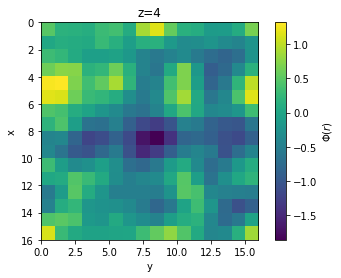

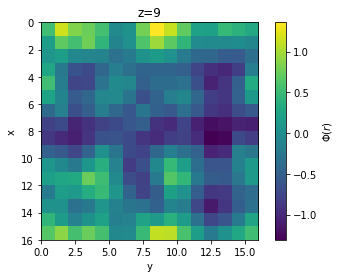

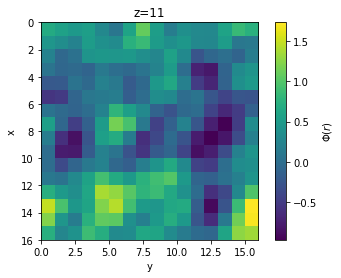

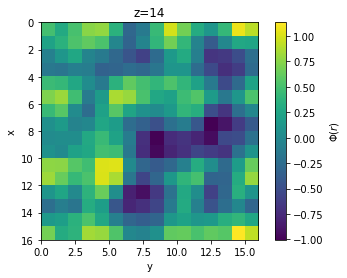

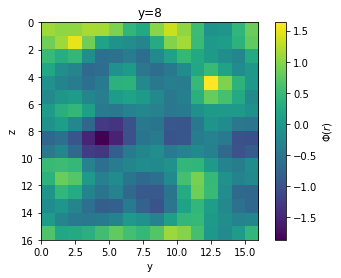

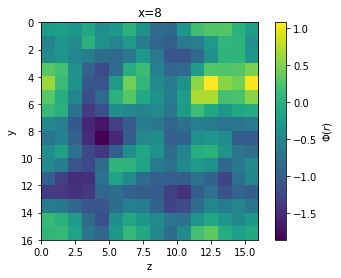

In [27]:
for z in [4,9,11,14]:
    plt.title(f"z={z}")
    plt.imshow(cic.potential[:,:,z],extent=[0,16,16,0])
    cbar = plt.colorbar()
    cbar.set_label('$\Phi (r)$')
    plt.xlabel('y')
    plt.ylabel('x')
#     plt.savefig('./test.pdf')
    plt.show()
    
# Also plot centered x-z and y-z plane
plt.title(f"y={8}")
plt.imshow(cic.potential[:,8,:],extent=[0,16,16,0])
cbar = plt.colorbar()
cbar.set_label('$\Phi (r)$')
plt.xlabel('y')
plt.ylabel('z')
#     plt.savefig('./test.pdf')
plt.show()

plt.title(f"x={8}")
plt.imshow(cic.potential[8,:,:],extent=[0,16,16,0])
cbar = plt.colorbar()
cbar.set_label('$\Phi (r)$')
plt.xlabel('z')
plt.ylabel('y')
#     plt.savefig('./test.pdf')
plt.show()



#### g) In simulations we often want to know the spatial gradient of the potential for the force. Use your potential field to calculate the gradient of the potential for the first 10 particles. Output the value of the gradient of the potential for these particles in all 3 spatial coordinates. It is important to realize that when assigning inferred quanities for particles they should be assigned with the same weighting as in the case of assiging the mass to the grid. Again use CIC.

In [30]:
# Calculate the gradient of the potential for the first 10 particles
# using inverse CIC to interpolate the gradients of neighbouring cells
pindices = np.array([0,1,2,3,4,5,6,7,8,9])
forces = cic.compute_force(pindices, cic.potential)
print ("Gradient of the potential of first 10 particles:")
print ("Columns denote x,y and z direction respectively")
print (forces)

Gradient of the potential of first 10 particles:
Columns denote x,y and z direction respectively
[[-2.44992268e-01  1.00834357e-01  1.53011613e-01]
 [ 1.85802947e-01  3.27191502e-01 -1.07063259e-01]
 [ 2.19600752e-01  1.58608943e-01 -3.84332257e-01]
 [ 2.56487620e-01  3.91320986e-01  3.98104892e-01]
 [-3.66060388e-01  7.71962461e-02 -5.36725450e-02]
 [-1.60055372e-01 -3.06982615e-04  3.89415953e-01]
 [ 2.43389615e-01 -3.70779866e-01  8.36958204e-02]
 [-8.57229404e-03  2.91506310e-01 -7.22998764e-03]
 [ 4.17161511e-01  2.73474545e-01  1.19689261e-01]
 [-9.51034550e-02  3.01974377e-01  1.63825212e-01]]
